### Projeto Módulo 1 -- Estimando Raio Efetivo

Aluna: Yasmin Cavalcante Ferreira Coelho

Esse jupyter notebook tem como objetivo ilustrar um exemplo do procedimento que realizei para estimar o raio efetivo do modelo de uma galáxia.
A galáxia utilizada nesse exemplo é NGC3381 e possui barra e disco em seu modelo de decomposição.

Mais informações sobre a decomposição e sobre os dados utilizados estão disponíveis no PDF enviado junto com esse notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi, exp
from scipy.optimize import curve_fit
from nim_irgalaxies import intferrer, exp_profile, exp_profile_enc 

In [2]:
#Abrindo a tabela com os dados que vamos usar

# obj -- nome do objeto
# comp -- componente do modelo (ex: BAR - barra, D - disco, B - bojo, N - nucleo)
# mod -- modelo de decomposição da galáxia na banda de 3.6 micrometros -- Decomposição feita por Salo et al. 2015
# decomposição disponível em: https://www.oulu.fi/astronomy/S4G_PIPELINE4/MAIN/
# Sobre essa tabela: ela possui uma linha para cada componente pois ela é a junção de 3 tabelas. A primeira tabela vem de Salo et al. 2015
# e é uma tabela com uma linha por componente. Como eu diversos momento precisei utilizar mais de uma tabela para as mesmas galáxias, juntei
# tudo em apenas uma tabela. A consequência disso é que há uma linha por componente da decomposição da galáxia, ou seja, se a galáxia 
# possui 3 componentes em seu modelo, ela possui 3 linhas nessa tabela e só a parte relacionada a Salo et al. 2015 varia nessas linhas. 
# Quando começa a parte relacionada a tabela do IRSA ou Bouquin et al. 2018, a linha apenas se repete.
# Note que entre parenteses ao lado da referencia, há o indicativo de quantas linhas essa tabela adicionou a tabela final.
obj, comp, mod = np.loadtxt("Salo15(4629)+IRSA_S4G(2352)+Bouquin18(1931)", dtype='str', delimiter=',', usecols=(1,5,2), unpack=True)

# mag3 -- magnitude observada da galáxia na banda de 3.6 micrometros
# mag4 -- magnitude observada da galáxia na banda de 4.5 micrometros (Não será usada nesse exemplo)
# fbar -- fracao da barra para o modelo 
# BAR_s0 -- brilho superficial da barra
# BAR_rout -- raio de truncamento da barra
# BAR_AR --  Axis ratio (b/a)  
# BAR_PA -- angulo de posição da barra
# fdisk -- fracao do disco para o modelo 
# D_mag -- magnitude da componente disco
# D_Rd -- disk scale length [pix]
# D_AR -- Axis ratio (b/a)  
# D_PA -- angulo de posição
# D_s0 -- brilho superficial do disco
mag3,mag4,fbar,BAR_s0,BAR_rout,BAR_AR,BAR_PA,fdisk,D_mag,D_Rd,D_AR,D_PA,D_s0=np.loadtxt("Salo15(4629)+IRSA_S4G(2352)+Bouquin18(1931)",
                                                                                        dtype='str', delimiter=',', 
                                                                                        usecols=(46,48,24,25,28,26,27,18,19,22,20,21,23),
                                                                                        unpack=True)

In [3]:
alpha = np.arange(0.1,15,0.1) #Valores para testarmos para o alpha
#Os valores de alpha que vão nos auxiliar nos possíveis valores de raio das componentes

r_int_possiveis = []
r_bar_int_possiveis = []
mag_bar_r = []
flux_bar_r = []
flux_expdisk_r = []
flux_expdisk_enc = []
flux_obs = []
flux_D_salo = []

i = 0 
while i < len(obj):
    #Note que mudando o nome da galáxia abaixo, esse processo pode ser repetido para qualquer galáxia que possua seu modelo de 
    #decomposição composto por disco + barra. É possível conferir o modelo de decomposição na tabela em anexo
    if obj[i] == 'NGC3381' and comp[i] == 'D': 
        print("Sobre o disco: ",fdisk[i],  D_mag[i], D_Rd[i], D_AR[i], D_PA[i], D_s0[i])
        
        for j in range(len(alpha)):
        ## Aqui cria a lista com os possíveis valores de raio para o disco
            r_int = alpha[j]*float(D_Rd[i])  ## raio do disco -- até onde calcular o fluxo
            r_int_possiveis.append(r_int)
            
            D_flux1 =  (np.power(10,float(D_s0[i])/-2.5)) #fluxo do disco -- a partir do brilho superficial Fluxo/arcsec^2
            
            flux_obs.append((np.power(10,float(mag3[i])/-2.5))) #criando a lista do fluxo observado -- a partir da mag 3.6 IRSA
         
            itotd = (np.power(10,float(D_mag[i])/-2.5)) #fluxo a partir da magnitude do disco -- para comparar o fluxo que calculamos
            flux_D_salo.append(itotd)
            
            D_re = float(D_Rd[i]) * 1.678 #raio efetivo do disco 
        
            S_expdisk = exp_profile(D_flux1, r_int,float(D_Rd[i])) #fluxo do disco
            flux_expdisk_r.append(S_expdisk)
    
            S_expdisk_enc = exp_profile_enc(D_flux1, r_int,float(D_Rd[i]), D_re) #fluxo do disco até certo raio
            flux_expdisk_enc.append(S_expdisk_enc)
            
        i = i +1
    
    if obj[i] == 'NGC3381' and comp[i] == 'BAR':
        #Agora, fazendo para barra -- os valores estão em outra linha
        print('Sobre a barra: ',fbar[i], BAR_s0[i], BAR_rout[i], BAR_AR[i], BAR_PA[i])
        for j in range(len(alpha)):
            BAR_flux = (np.power(10,float(BAR_s0[i])/-2.5)) #fluxo da barra -- a partir do brilho superficial Fluxo/arcsec^2 
            
            #Condição para utilizar os valores possíveis de raio do disco, lista criada acima junto a componente disco
            #Essa condição é necessária pois em alguns casos, o raio da barra era maior que o raio do disco. Essa condição irá nos 
            #ajudar a ficar dentro desse raio estimado.
            for k in range(len(r_int_possiveis)):  
                rbar = float(BAR_rout[i])
                if (float(BAR_rout[i]) > r_int_possiveis[k]):
                    rbar = r_int_possiveis[k]
                    
                    if len(r_bar_int_possiveis) == len(r_int_possiveis):
                        break 
                r_bar_int_possiveis.append(rbar) #possiveis valores de raio para a barra
            
                            
            s1 = intferrer(r_bar_int_possiveis[j],float(BAR_rout[i]),BAR_flux)  ## fluxo da barra até certo raio
            flux_bar_r.append(s1)
        
        i = i +1
        
    else:
        i = i +1

Sobre o disco:  0.892 12.571 16.36 0.841 57.04 20.636
Sobre a barra:  0.108 20.111 27.3 0.161 77.16


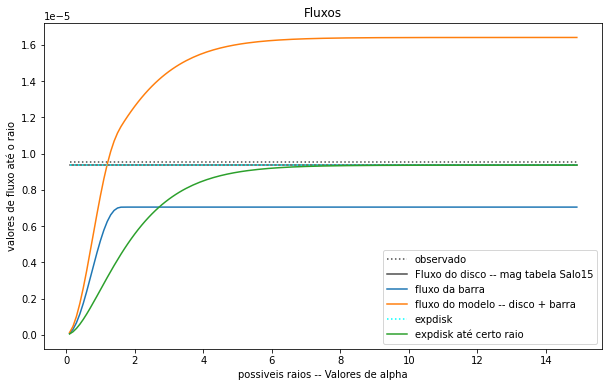

In [4]:
# Aqui vamos ilustrar o que conseguimos até agora. O que queremos analisar melhor é o momento em que o fluxo do modelo supera 
# o fluxo observado.
flux_mod = []

for k in range(len(flux_expdisk_r)):
    flux_modelo = (flux_expdisk_enc[k] + flux_bar_r[k])
    flux_mod.append(flux_modelo)
     
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(1,1,1)

ax1.set_title('Fluxos')
ax1.plot(alpha,flux_obs,'k:',alpha = 0.7, label='observado')
ax1.plot(alpha,flux_D_salo,'k-',alpha = 0.7,label='Fluxo do disco -- mag tabela Salo15')
ax1.set_xlabel('possiveis raios -- Valores de alpha')
ax1.set_ylabel('valores de fluxo até o raio')
ax1.plot(alpha,flux_bar_r,label='fluxo da barra')
ax1.plot(alpha,flux_mod,label='fluxo do modelo -- disco + barra')
ax1.plot(alpha,flux_expdisk_r,':',color='cyan',alpha = 1, label='expdisk')
ax1.plot(alpha,flux_expdisk_enc, label='expdisk até certo raio')
ax1.legend(loc='best')

plt.show()

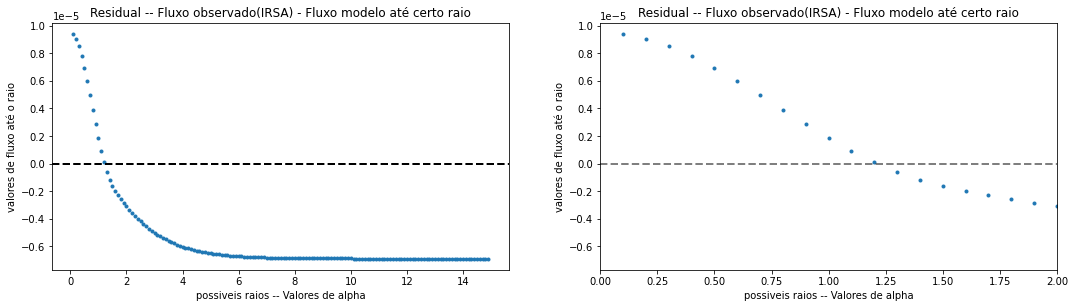

In [5]:
#Calculando o residual
flux_res = []
flux_mod = []

for k in range(len(flux_expdisk_r)):
    flux_modelo = (flux_expdisk_enc[k] + flux_bar_r[k]) #fluxo modelo = fluxo disco(até certo raio) + fluxo barra
    flux_ = flux_obs[k] - (flux_expdisk_enc[k] + flux_bar_r[k]) #fluxo observado - fluxo modelo
    flux_mod.append(flux_modelo)
    flux_res.append(flux_)
    
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

ax1.set_title('Residual -- Fluxo observado(IRSA) - Fluxo modelo até certo raio')
ax1.plot(alpha,flux_res,'.', label='até certo raio')
ax1.axhline(0, color='k', ls='--', lw=2)
ax1.set_xlabel('possiveis raios -- Valores de alpha')
ax1.set_ylabel('valores de fluxo até o raio')

ax2.set_title('Residual -- Fluxo observado(IRSA) - Fluxo modelo até certo raio')
ax2.plot(alpha,flux_res,'.', label='até certo raio')
ax2.axhline(0, color='k', ls='--',alpha = 0.5, lw=2)
ax2.set_xlim(0,2)
ax2.set_xlabel('possiveis raios -- Valores de alpha')
ax2.set_ylabel('valores de fluxo até o raio')

plt.show()

In [6]:
#Definindo algumas funções para criar dois possíveis ajustes e então, testar eles.
def reta(x,b0,b1):
    valores_x = []
    valores_f = []
    i= 0 
    while i < len(x):
        f = b0 + b1 * x[i]
        valores_x.append(x[i])
        valores_f.append(f)
        i = i + 1  
    return valores_f

def poli3(x,a,b,c,d):
    valores_x = []
    valores_f = []
    i= 0 
    while i < len(x):
        f = a*(x[i])**3 + b*(x[i])**2 + c*x[i] + d
        valores_x.append(x[i])
        valores_f.append(f)
        i = i + 1
    return valores_f

def residuo_quadrado(data, modelo):
    subtr = []
    for i in range(len(data)):
        subtr.append((data[i] - modelo[i])**2)
    resultado = np.sum((subtr))
    return resultado

Parametros para o ajuste 1:  [ 1.12124486e-05 -9.12242759e-06] 

 Variância e covariância do ajuste 1: 
 [[ 1.01839414e-13 -9.54744507e-14]
 [-9.54744507e-14  9.54744507e-14]]

 Incertezas:  [3.19122882e-07 3.08989402e-07]

 ------------------------------------------------------------------------------------------
Parametros para o ajuste 2:  [ 3.26538858e-06 -7.91115677e-06 -3.35287366e-06  1.00278037e-05] 

 Variância e covariância do ajuste 2: 
 [[ 1.04446621e-13 -3.13339862e-13  2.57147574e-13 -4.82543357e-14]
 [-3.13339862e-13  9.63654359e-13 -8.18712270e-13  1.61307350e-13]
 [ 2.57147574e-13 -8.18712270e-13  7.33261488e-13 -1.57515934e-13]
 [-4.82543357e-14  1.61307350e-13 -1.57515934e-13  4.11871417e-14]]

 Incertezas:  [3.23182025e-07 9.81658983e-07 8.56306889e-07 2.02946155e-07]


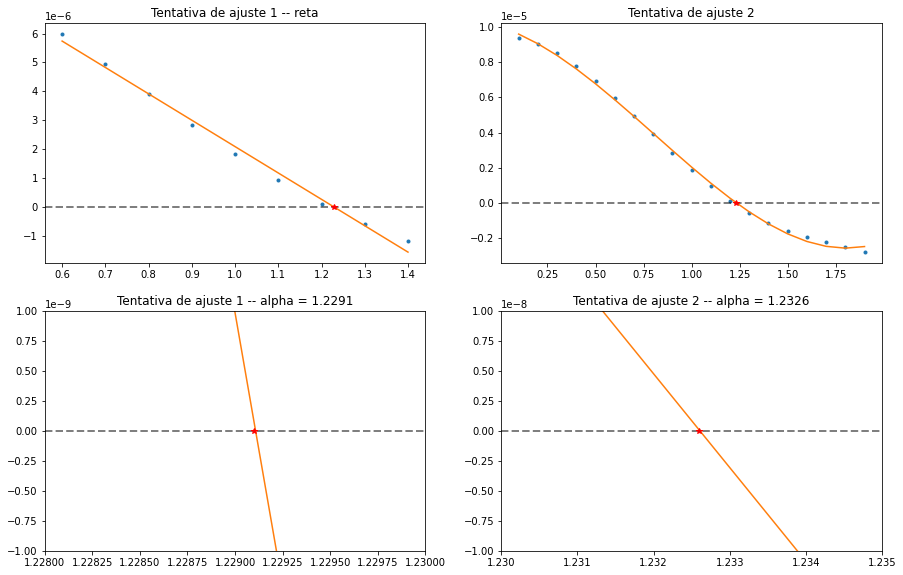

In [7]:
corte_flux_res = []
corte_alpha = []

corte_flux_res2 = []
corte_alpha2 = []

for i in range(len(flux_res)):
    if alpha[i] > 0.5 and alpha[i] < 1.5: #primeiro corte
        
        corte_alpha.append(alpha[i])
        corte_flux_res.append(flux_res[i])
       
    
for i in range(len(flux_res)):
    if alpha[i] > 0.0001 and alpha[i] < 2.0: #segundo corte
        
        corte_alpha2.append(alpha[i])
        corte_flux_res2.append(flux_res[i])    

#-------------- PRIMEIRA TENTATIVA DE AJUSTE        
ajuste = reta(x = corte_alpha, b0 = 1.12124486e-05, b1 = -9.12242759e-06)

parameters, covariance = curve_fit(reta, corte_alpha, corte_flux_res, p0=[0.3, 1])
print('Parametros para o ajuste 1: ', parameters, '\n\n','Variância e covariância do ajuste 1: \n', covariance)

error = np.sqrt(np.diagonal(covariance))
print('\n Incertezas: ', error)
print('\n ------------------------------------------------------------------------------------------')
#-------------- SEGUNDA TENTATIVA DE AJUSTE
ajuste2 = poli3(x = corte_alpha2, a= 3.26538858e-06, b= -7.91115677e-06, c= -3.35287366e-06, d=  1.00278037e-05)

parameters2, covariance2 = curve_fit(poli3, corte_alpha2, corte_flux_res2, p0=[1,0.3, 1,1])
print('Parametros para o ajuste 2: ',parameters2, '\n\n','Variância e covariância do ajuste 2: \n', covariance2)

error2 = np.sqrt(np.diagonal(covariance2))
print('\n Incertezas: ', error2)

#--------------------------------------------------------
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)

ax1.plot(corte_alpha,corte_flux_res,'.', label='até certo raio')
ax1.plot(corte_alpha,ajuste, label='até certo raio')
ax1.set_title('Tentativa de ajuste 1 -- reta')
ax1.axhline(0, color='k', ls='--',alpha = 0.5, lw=2)
ax1.plot(1.2291, 0, 'r*')

ax2.plot(corte_alpha2,corte_flux_res2,'.', label='até certo raio')
ax2.plot(corte_alpha2,ajuste2, label='até certo raio')
ax2.axhline(0, color='k', ls='--',alpha = 0.5, lw=2)
ax2.set_title('Tentativa de ajuste 2')
ax2.plot(1.2326, 0, 'r*')

ax3.plot(corte_alpha,corte_flux_res,'.', label='até certo raio')
ax3.plot(corte_alpha,ajuste, label='até certo raio')
ax3.set_title('Tentativa de ajuste 1 -- alpha = 1.2291')
ax3.axhline(0, color='k', ls='--',alpha = 0.5, lw=2)
ax3.plot(1.2291, 0, 'r*')
ax3.set_xlim(1.228,1.23)
ax3.set_ylim(-1*10**(-9),1*10**(-9))

ax4.plot(corte_alpha2,corte_flux_res2,'.', label='até certo raio')
ax4.plot(corte_alpha2,ajuste2, label='até certo raio')
ax4.set_title('Tentativa de ajuste 2 -- alpha = 1.2326')
ax4.axhline(0, color='k', ls='--',alpha = 0.5, lw=2)
ax4.plot(1.2326, 0, 'r*')
ax4.set_xlim(1.230,1.235)
ax4.set_ylim(-1*10**(-8),1*10**(-8))

plt.show()

#### Qual seria o melhor modelo? 

In [8]:
print('\n Soma dos quadrados dos residuos (modelo1 -- reta):', residuo_quadrado(data=corte_flux_res, modelo=ajuste))

subt = []
for i in range(len(corte_flux_res)):
    subt.append(corte_flux_res[i] - ajuste[i])

chi_2 = residuo_quadrado(data=corte_flux_res, modelo=ajuste)/(np.std(subt)**2)
print('Chi2: ',chi_2)

N = len(corte_flux_res)
M = len(parameters)

#print(np.std(y - y_modelo))
print('\n Numero de pontos para o ajuste 1 (Valor de N) : ', len(corte_flux_res))
print('Numero de parametros necessários para o ajuste: ', len(parameters))
print('Chi2/(N - M): ', chi_2/(N - M))

#-----------------------------------------------------------------------
print('\n Soma dos quadrados dos residuos (modelo2 -- polinomio de grau 3) :', residuo_quadrado(data=corte_flux_res2, modelo=ajuste2))

subt2 = []
for i in range(len(corte_flux_res2)):
    subt2.append(corte_flux_res2[i] - ajuste2[i])

chi_2_2 = residuo_quadrado(data=corte_flux_res2, modelo=ajuste2)/(np.std(subt2)**2)
print('Chi2: ',chi_2_2)
#chi2 por grau de liberdade chi_2/(N-M) M-- numero de pontos, N -- numero de parametros

#numero de pontos -
N2 = len(corte_flux_res2)
M2 = len(parameters2)
print('\n Numero de pontos para o ajuste 2 (Valor de N) : ', len(corte_flux_res2))
print('Numero de parametros necessários para o ajuste: ', len(parameters2))
print('Chi2/(N - M): ', chi_2_2/(N2 - M2))


 Soma dos quadrados dos residuos (modelo1 -- reta): 4.0099269402862126e-13
Chi2:  9.000000000000133

 Numero de pontos para o ajuste 1 (Valor de N) :  9
Numero de parametros necessários para o ajuste:  2
Chi2/(N - M):  1.2857142857143047

 Soma dos quadrados dos residuos (modelo2 -- polinomio de grau 3) : 4.809440794513232e-13
Chi2:  19.00000000000159

 Numero de pontos para o ajuste 2 (Valor de N) :  19
Numero de parametros necessários para o ajuste:  4
Chi2/(N - M):  1.2666666666667727


In [9]:
#Qual dos dois modelos é o melhor? -- f-test

import scipy.stats as stats

def f_test(x, y, p1, p2):
    f = np.var(x, ddof=p1)/np.var(y, ddof=p2) #calculate F test statistic 
    return f

#Residuos --  fluxo - ajuste
res1 = []
res2 = []
for i in range(len(corte_flux_res)):
    y = corte_flux_res[i] - ajuste[i]
    res1.append(y)
    
for i in range(len(corte_flux_res2)):
    y = corte_flux_res2[i] - ajuste2[i]
    res2.append(y)

# Valor crítico !
valor_critico = stats.f.ppf(q=0.68, dfn=9-2, dfd=19-4)
print('Valor crítico (1 sigma): ', valor_critico)
print('Valor crítico (2 sigmas): ', stats.f.ppf(q=0.954, dfn=9-2, dfd=19-4))
print('Valor crítico (3 sigmas): ', stats.f.ppf(q=0.9973, dfn=9-2, dfd=19-4))
#q: The significance level to use (0 ~ 1.0)
#dfn: The numerator degrees of freedom
#dfd: The denominator degrees of freedom

#o f tem que ser maior que o valor critico para que o segundo modelo seja melhor que o primeiro
#o modelo 2 é melhor que o modelo 1?
ftest = f_test(x=res1, y=res2, p1=2, p2=4)
print('Valor do f test: ',ftest)

print('\nEntão, considerando 2 sigmas acaba valendo mais a pena utilizar o modelo 1.')

Valor crítico (1 sigma):  1.2889551790093945
Valor crítico (2 sigmas):  2.775003176892052
Valor crítico (3 sigmas):  5.527233595280196
Valor do f test:  1.7866319502531403

Então, considerando 2 sigmas acaba valendo mais a pena utilizar o modelo 1.


No entanto, se fizermos o teste inverso, temos:

In [26]:
cdf = stats.f.cdf(1.7866319502531403, dfn=9-2, dfd=19-4)

print('O inverso do valor f test nos diz que o modelo 2 se ajusta melhor que o modelo 1 em %.3f' %cdf, '% dos casos.')

O inverso do valor f test nos diz que o modelo 2 se ajusta melhor que o modelo 1 em 0.837 % dos casos.


### Então... Qual é o melhor raio?

O modelo 2 possui mais parâmetros e assim é mais completo. Até chegarmos a fazer o o inverso do f test, o modelo 1 seria mais vantajoso por ser mais simples e se mostrar como uma boa aproximação, no entanto, após o último teste feito vimos que o modelo 2 se ajusta melhor que o modelo 1 em 84 % dos casos. 
Devido a isso, se torna melhor utilizar o modelo 2.


Abaixo os valores de raio considerando os dois modelos:

In [27]:
alpha1 = 1.2291
alpha2 = 1.2326

for i in range(len(obj)):
    if obj[i] == 'NGC3381' and comp[i] == 'D':
        
        r_int1 = alpha1*float(D_Rd[i])  ## raio do disco
    
        r_int2 = alpha2*float(D_Rd[i])
        
        D_re = float(D_Rd[i]) * 1.678
        
print('Considerando alpha 1: %.3f' %r_int1,'\nConsiderando alpha 2: %.3f' %r_int2) #pix

Considerando alpha 1: 20.108 
Considerando alpha 2: 20.165
